In [10]:
import pandas as pd
import numpy as np 
import sklearn as sk 
from hmmlearn import hmm
import matplotlib.pyplot as plt
import yfinance as yf

### Write the back-test function first that creates the signal of interest

In [8]:
def generate_signal(start, end, X, states, window, delay):
    np.random.seed(22)
    signal = []
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    
    for i in range(0, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        signal.append(predictions[-1])
        
    return signal

In [110]:
def generate_signal_rolling(start, end, X, states, window, delay):
    np.random.seed(22)
    signal = []
    count = 0
    
    X = X.reshape(-1, 1)
    
    model = hmm.GaussianHMM(n_components=states, covariance_type="diag", n_iter=1000, init_params="")
    model.fit(X[start-window:start])
    predictions = model.predict(X[start-window:start])
    signal.append(predictions[-1])
    prev_pred = predictions[-1]
    
    for i in range(1, end-start):
        model.fit(X[start-window+i:start+i])
        predictions = model.predict(X[start-window+i:start+i])
        pred = predictions[-1]
        
        if pred == prev_pred:
            count = count + 1 
            
        elif pred != prev_pred:
            count = 1
            
        if count >= delay:
            signal.append(pred)
            
        elif count < delay:
            signal.append(signal[-1])
            
        prev_pred = pred
        
    if signal.count(0) > signal.count(1):
        signal = abs(np.array(signal) - 1)
        
    else: 
        signal = np.array(signal)
        
        
    return signal

In [108]:
# importing the data
ticker = yf.Ticker('MSFT')
msft = ticker.history(period="15y")
msft["Returns"] = msft["Close"].pct_change()
idx = msft.index[start:]

# initialising function parameters
start = 3020
end = len(msft)
X = msft["Returns"].values
window = 1008
delay = 7
states = 2

# calling function
signal = generate_signal_rolling(start, end, X, states, window, delay)

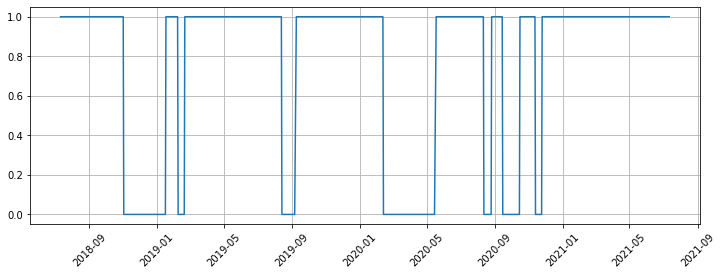

In [109]:
# plotting signal 
plt.figure(figsize=(12,4))
plt.plot(idx, signal)
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [120]:
price = msft[start+1:end]["Open"]

def backtest_signal(price, signal):
    w = np.zeros(np.shape(price))
    cash = np.zeros(np.shape(price))
    cash[0] = 10000

    for i in range(0, len(price)):

        if i == len(price)-1:
            break

        if signal[i] == 1: 
            w[i+1] = cash[i]/price[i+1]  + w[i]
            cash[i+1] = 0

        elif signal[i] == 0:
            cash[i+1] = w[i]*price[i+1] + cash[i]
            w[i+1] = 0
            
    strat = [a*b for a,b in zip(w[:-1], price)] + cash[:-1]
    
    return strat

strat = backtest_signal(price, signal)

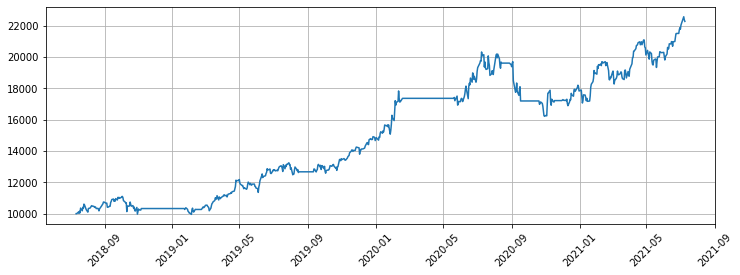

In [126]:
plt.figure(figsize=(12,4))
plt.plot(idx[1:-1], strat)
plt.xticks(rotation=45)
plt.grid()
plt.show()